In [1]:
import numpy as np
from TDD.TDD import Index,get_int_key,get_unique_table,get_identity_tdd,get_count
from TDD.TDD import Ini_TDD,TDD,diag_matrix_2_TDD,cnot_2_TDD,Slicing,cont,Single_qubit_gate_2TDD
from TDD.TDD_show import TDD_show,TDD_show2
from cir_input.qasm import CreateCircuitFromQASM
from cir_input.circuit_DG import CreateDGfromQASMfile
import time
import datetime
import copy
import pandas as pd
from func_timeout import func_set_timeout
import func_timeout

In [2]:
#将电路标上index，使其能够按照tensor来操作
def get_tensor_index(cir, num_qubit):
    """return a dict that link every quantum gate to the corresponding index"""
    qubits_index=[0]*num_qubit
    dict1=dict()
    hyper_index=dict()
    for k in cir.nodes():
        operation=cir.nodes[k]['operation']
        nam=operation.name
        if nam != 'CX':
            q=operation.involve_qubits[0]
            var_in='x'+ str(q)+str(0)+str(qubits_index[q])
            var_out='x'+ str(q)+str(0)+str(qubits_index[q]+1)
            if not var_in in hyper_index:
                    hyper_index[var_in]=0
            if not var_out in hyper_index:
                    hyper_index[var_out]=0
            if nam =='z' or nam == 't' or nam == 's'or nam == 'tdg' or nam == 'sdg'or nam == 'rz':
                dict1[k]=[Index(var_in,hyper_index[var_in]),Index(var_in,hyper_index[var_in]+1)]
                hyper_index[var_in]+=1
            else:
                dict1[k]=[Index(var_in,hyper_index[var_in]),Index(var_out,hyper_index[var_out])]
                qubits_index[q]+=1
        else:
            q=[operation.control_qubit,operation.target_qubit]
            var_con='x'+ str(q[0])+str(0)+str(qubits_index[q[0]])
            var_tar_in='x'+ str(q[1])+str(0)+str(qubits_index[q[1]])
            var_tar_out='x'+ str(q[1])+str(0)+str(qubits_index[q[1]]+1)
            if not var_con in hyper_index:
                hyper_index[var_con]=0
            if not var_tar_in in hyper_index:
                hyper_index[var_tar_in]=0
            if not var_tar_out in hyper_index:
                hyper_index[var_tar_out]=0                      
            dict1[k]=[Index(var_con,hyper_index[var_con]),Index(var_con,hyper_index[var_con]+1),Index(var_con,hyper_index[var_con]+2),Index(var_tar_in,hyper_index[var_tar_in]),Index(var_tar_out,hyper_index[var_tar_out])]         
            hyper_index[var_con]+=2
            qubits_index[q[1]]+=1
        
    for k in range(num_qubit):
        last1='x'+str(k)+str(0)+str(qubits_index[k])
        new1='y'+str(k)
        last2='x'+str(k)+str(0)+str(0)
        new2='x'+str(k)
        for m in dict1:
            dict1[m]=[Index(new1,item.idx) if item.key ==last1 else item for item in dict1[m]]
            dict1[m]=[Index(new2,item.idx) if item.key ==last2 else item for item in dict1[m]]

    return dict1

In [3]:
#将对应的量子门转化为TDD
def get_tdd(operation,var_list,involve_qubits):
    """get the TDD of the correct part of quantum gate"""
    nam=operation.name
    if nam =='z' or nam == 't' or nam == 's'or nam == 'tdg' or nam == 'sdg'or nam == 'rz':
        return diag_matrix_2_TDD(operation.u_matrix,var_list)
    elif nam =='CX':
        if operation.control_qubit in involve_qubits and operation.target_qubit in involve_qubits:
            return cnot_2_TDD(var_list,case=1)
        if operation.control_qubit in involve_qubits and not operation.target_qubit in involve_qubits:
            return cnot_2_TDD(var_list,case=2)
        else:
            return cnot_2_TDD(var_list,case=3)
    else:
        return Single_qubit_gate_2TDD(operation.u_matrix,var_list)

In [4]:
#计算电路划分之后一块电路的TDD
def get_tdd_of_a_part_circuit(involve_nodes,involve_qubits,cir,node_var):
    """get the TDD of a part of circuit"""
#     compute_time = time.time()
    tdd=get_identity_tdd()
    max_node_num = 0
    for k in involve_nodes:
        temp_tdd=get_tdd(cir.nodes[k]['operation'],node_var[k],involve_qubits)
        tdd=cont(tdd,temp_tdd)
        max_node_num=max(max_node_num,tdd.node_number())
#     print('get_part_time:',time.time()-compute_time)
    return tdd,max_node_num

In [5]:
#第一种划分方案
def circuit_partion1(cir,num_qubit,cx_max,node_var,qubits_reorder=False):
    """The first partition scheme; 
    cir is a dag circuit;
    cx_max is the number of CNOTs allowed to be cut
    """
    res=[[[],[]]]
    cx_num=0
    level=0
    qubits=[]
    cut_cx_idx=[]
    if qubits_reorder:
        temp_qubits = get_qubit_partition(cir)
        temp_qubits = temp_qubits[0]+temp_qubits[1]
        qubit_per=dict()
        for k in range(num_qubit):
            qubit_per[temp_qubits[k]] = k
        relabel_qubits(cir,qubit_per)
        
    qubits = []    
    qubits.append([k for k in range(num_qubit//2)])
    qubits.append([k for k in range(num_qubit//2,num_qubit)])

    for k in cir.nodes():
        opera=cir.nodes[k]['operation']
        nam=opera.name
        if nam!='CX':
            if opera.involve_qubits[0] in qubits[0]:
                res[level][0].append(k)
            else:
                res[level][1].append(k)
        else:
            if opera.control_qubit in qubits[0] and opera.target_qubit in qubits[0]:
                res[level][0].append(k)
            elif opera.control_qubit in qubits[1] and opera.target_qubit in qubits[1]:
                res[level][1].append(k)
            else:
                cx_num+=1
                if cx_num<=cx_max:
                    res[level][0].append(k)
                    res[level][1].append(k)
                else:
                    level+=1
                    res.append([])
                    res[level].append([])
                    res[level].append([])
                    res[level][0].append(k)
                    res[level][1].append(k)
                    cx_num=1
    print('circuit blocks:',2*(level+1))
    return res,qubits

In [6]:
#第二种划分方案
def circuit_partion2(cir,num_qubit,cx_max,c_part_width,node_var,qubits_reorder=False):
    """cir is a dag circuit;
    num_qubit is the real qubit number of the circuit;
    cx_max is the number of CNOT that allowed to be cut
    c_part_width is the allowed qubit numbers of the C part;
    """
    res=[[[],[],[]]]
    cx_num=0
    level=0
    
    if qubits_reorder:
        temp_qubits = get_qubit_partition(cir)
        temp_qubits = temp_qubits[0]+temp_qubits[1]
        qubit_per=dict()
        for k in range(num_qubit):
            qubit_per[temp_qubits[k]] = k
        relabel_qubits(cir,qubit_per)    
    
    qubits=[]
    qubits.append([k for k in range(num_qubit//2)])
    qubits.append([k for k in range(num_qubit//2,num_qubit)])
    qubits.append([])
    c_range=[num_qubit,0]
    for k in cir.nodes():
        opera=cir.nodes[k]['operation']
        nam=opera.name
        if nam!='CX':
            if opera.involve_qubits[0] in qubits[0]:
                res[level][0].append(k)
            elif opera.involve_qubits[0] in qubits[1]:
                res[level][1].append(k)
            else:
                res[level][2].append(k)
        else:
            if opera.control_qubit in qubits[0] and opera.target_qubit in qubits[0]:
                res[level][0].append(k)
            elif opera.control_qubit in qubits[1] and opera.target_qubit in qubits[1]:
                res[level][1].append(k)
            elif opera.control_qubit in qubits[2] and opera.target_qubit in qubits[2]:
                res[level][2].append(k)
            else:
                if cx_num < cx_max:
                    cx_num+=1
                    res[level][0].append(k)
                    res[level][1].append(k)
                else:
                    c_width=max(c_range[1],max(opera.involve_qubits))-min(c_range[0],min(opera.involve_qubits))+1
                    if c_width<c_part_width:
                        res[level][2].append(k)
                        c_range[0]=min(c_range[0],min(opera.involve_qubits))
                        c_range[1]=max(c_range[1],max(opera.involve_qubits))
                        qubits[0]=[k for k in range(0,c_range[0])]
                        qubits[1]=[k for k in range(c_range[1]+1,num_qubit)]
                        qubits[2]=[k for k in range(c_range[0],c_range[1]+1)]
                    else:
                        level+=1
                        res.append([])
                        res[level].append([])
                        res[level].append([])
                        res[level].append([])
                        qubits.clear()
                        qubits.append([k for k in range(num_qubit//2)])
                        qubits.append([k for k in range(num_qubit//2,num_qubit)])
                        qubits.append([])
                        c_range=[num_qubit,0]
                        if opera.control_qubit in qubits[0] and opera.target_qubit in qubits[0]:
                            res[level][0].append(k)
                            cx_num=0
                        elif opera.control_qubit in qubits[1] and opera.target_qubit in qubits[1]:
                            res[level][1].append(k)
                            cx_num=0
                        else:
                            res[level][0].append(k)
                            res[level][1].append(k)
                            cx_num=1
    print('circuit blocks:',3*(level+1))
    return res

In [7]:
# @func_set_timeout(3600)
def Simulation_with_cir_partion(cir, num_qubit,partion_scheme=0,cx_max=2,c_part_width=2):
    """Simulate a circuit with TDD;
    cir is a dag circuit;
    num_qubit is the real qubit number of the circuit;
    partition_scheme = 0, 1, 2
    cx_max is the number of CNOT that allowed to be cut in two partition scheme
    c_part_width is the allowed qubit numbers of the C part in the second partition scheme;
    return the result tdd and other corresponding information
    """
    var_order=[]
    gate_num=len(cir.nodes)
        
    for k in range(num_qubit-1,-1,-1):
        var_order.append('x'+str(k))
        for j in range(gate_num):
            var_order.append('x'+str(k)+str(0)+str(j))
        var_order.append('y'+str(k))
    
    node_var = get_tensor_index(cir, num_qubit)
    
    max_node_num = 0
#     print(var_order)
    Ini_TDD(var_order)
    if partion_scheme==0:
        involve_qubits=[k for k in range(num_qubit)]
        tdd,max_node_num = get_tdd_of_a_part_circuit(cir.nodes,involve_qubits,cir,node_var)
        return tdd, max_node_num,1
    
    
    if partion_scheme==1:
        partion_cir,involve_qubits=circuit_partion1(cir,num_qubit,cx_max,node_var)
        tdd = get_identity_tdd()
        max_node_num = max(max_node_num,tdd.node_number())
        for level in range(len(partion_cir)):
            loop_time=time.time()
#             print('now is processing level:',level)
            tdd1,node_num1=get_tdd_of_a_part_circuit(partion_cir[level][0],involve_qubits[0],cir,node_var)
            max_node_num = max(max_node_num,node_num1)
            tdd2,node_num2=get_tdd_of_a_part_circuit(partion_cir[level][1],involve_qubits[1],cir,node_var)
            max_node_num = max(max_node_num,node_num2)
            temp_tdd=cont(tdd1,tdd2)
            max_node_num = max(max_node_num,temp_tdd.node_number())
            tdd=cont(tdd,temp_tdd)
            max_node_num = max(max_node_num,tdd.node_number())
#             print('loop_time:',time.time()-loop_time)
        return tdd, max_node_num,2*len(partion_cir)
    
    if partion_scheme==2:
        compute_time = time.time()
        involve_qubits=[]
        involve_qubits.append([k for k in range(num_qubit//2)])
        involve_qubits.append([k for k in range(num_qubit//2,num_qubit)])
        involve_qubits.append([k for k in range(num_qubit)])
        partion_cir=circuit_partion2(cir,num_qubit,cx_max,c_part_width,node_var)
        tdd=get_identity_tdd()
        max_node_num = max(max_node_num,tdd.node_number())
        for level in range(len(partion_cir)):
            tdd1,node_num1=get_tdd_of_a_part_circuit(partion_cir[level][0],involve_qubits[0],cir,node_var)
            max_node_num = max(max_node_num,node_num1)
            
            tdd2,node_num2=get_tdd_of_a_part_circuit(partion_cir[level][1],involve_qubits[1],cir,node_var)
            max_node_num = max(max_node_num,node_num2)
            temp_tdd=cont(tdd1,tdd2)
            max_node_num = max(max_node_num,temp_tdd.node_number())
            
            tdd3,node_num3=get_tdd_of_a_part_circuit(partion_cir[level][2],involve_qubits[2],cir,node_var)
            max_node_num = max(max_node_num,node_num3)
            
            temp_tdd=cont(tdd3,temp_tdd)
            max_node_num = max(max_node_num,temp_tdd.node_number())
            
            tdd=cont(tdd,temp_tdd)
            max_node_num = max(max_node_num,tdd.node_number())
            
        return tdd,max_node_num,3*len(partion_cir)

In [8]:
#设置time out，要使用此功能需要func_timeout包
def Simulation_with_time_out(cir, num_qubit,partion_scheme=0,cx_max=2,c_part_width=2):
    try:
        return Simulation_with_cir_partion(cir, num_qubit,partion_scheme,cx_max,c_part_width)
    except:
        print('Time out!')
        node = Find_Or_Add_Unique_table(1,0,0,None,None)
        tdd = TDD(node)
        return tdd,0,0

In [9]:
#计算一个电路的真实比特数与门数
def get_real_qubit_num(cir):
    qubit_num=0
    for k in cir.nodes():
        temp=max(cir.nodes[k]['operation'].involve_qubits)
        qubit_num=max(qubit_num,temp)
    qubit_num+=1
    return qubit_num

def get_gates_number(cir):
    return len(cir.nodes)

circuit: 3_17_13.qasm
qubits: 3
gates number: 36
circuit blocks: 20
max_node_num: 24
run_time: 0.06205320358276367
final nodes: 20
448 [888, 488] [400, 40]


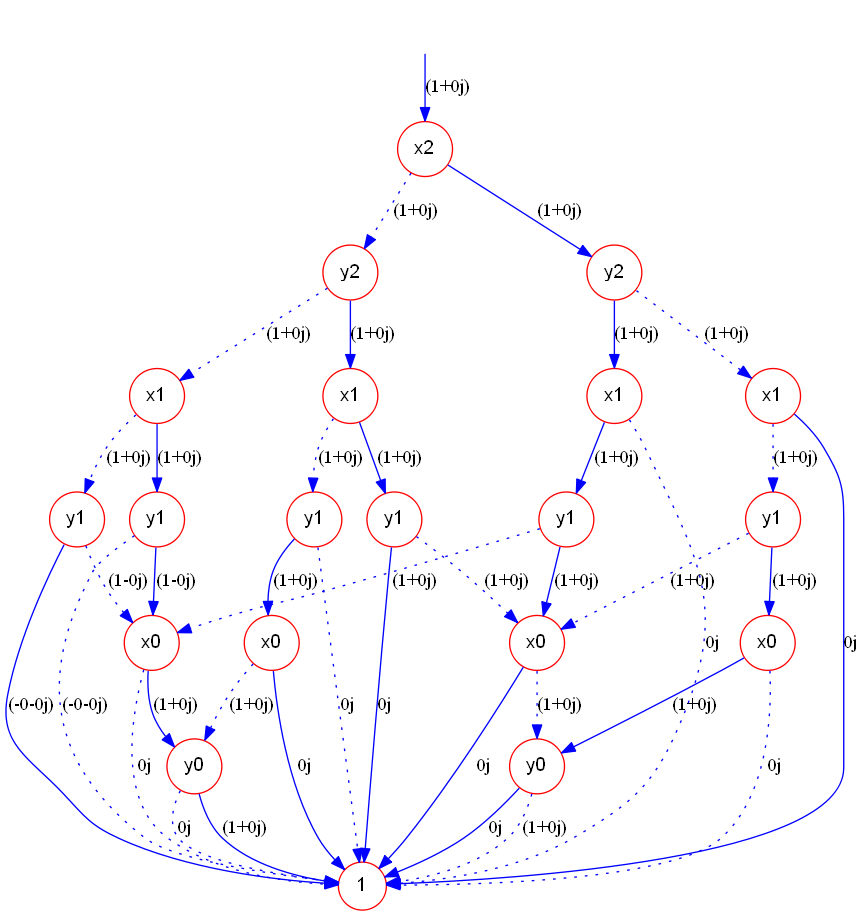

In [10]:
#生成电路并仿真
path='Benchmarks/'
file_name = '3_17_13.qasm'
cir1,res1 = CreateDGfromQASMfile(file_name, path, flag_single=True,flag_interaction=True)
dag_cir1=res1[0]
print('circuit:',file_name)
num_qubit = get_real_qubit_num(dag_cir1)
print('qubits:',num_qubit)
gate_num = get_gates_number(dag_cir1)
print('gates number:',gate_num)
t_start = time.time()
tdd,max_node_num,block_num=Simulation_with_cir_partion(dag_cir1, num_qubit,partion_scheme=1,cx_max=num_qubit//2,c_part_width=num_qubit//2+1)
run_time=time.time()-t_start
print('max_node_num:',max_node_num)
print('run_time:',run_time)
print('final nodes:',tdd.node_number())
get_count()
TDD_show2(tdd)

In [11]:
# path='Benchmarks/'
# file_list = open('test.txt','r')
# excel_path = 'data.xlsx'
# result=[]
# with open('computed_tdd.txt','r') as f:
#     for line in f:
#         result.append(line[:-1])

# data=["Partition0"]        
# data=np.array(data).reshape(1,len(data))
# df = pd.read_excel(excel_path, header=None)
# ds = pd.DataFrame(data)
# df = df.append(ds, ignore_index=True)
# df.to_excel(excel_path, index=False, header=False) 
        
# for file in file_list.readlines():
#     file_name=file[:-1]

#     if file_name in result:
#         continue
#     print(file_name)
#     try:
#         cir1,res1 = CreateDGfromQASMfile(file_name, path, flag_single=True,flag_interaction=True)
#     except:
#         continue
#     dag_cir1=res1[0]
#     num_qubit = get_real_qubit_num(dag_cir1)
#     print('qubits:',num_qubit)
#     gate_num = get_gates_number(dag_cir1)
#     print('gates number:',gate_num)
    
# #     if gate_num>1000:
# #         continue
#     data = []
#     data.append(file_name)
#     data.append(num_qubit)
#     data.append(gate_num)
#     time_now = datetime.datetime.now()
#     print(time_now.strftime('%m.%d-%H:%M:%S'))
#     t_start = time.time()
#     tdd,node_num,block_num=Simulation_with_cir_partion(dag_cir1, num_qubit,partion_scheme=0,cx_max=num_qubit//2)
#     run_time=time.time()-t_start
#     print(run_time)
#     data.append(run_time)
#     data.append(node_num)
#     data.append(block_num)
#     tdd_nodes = tdd.node_number()
#     print(tdd_nodes)
#     data.append(tdd_nodes)  
    
#     data=np.array(data).reshape(1,len(data))
#     df = pd.read_excel(excel_path, header=None)
#     ds = pd.DataFrame(data)
#     df = df.append(ds, ignore_index=True)
#     df.to_excel(excel_path, index=False, header=False)
#     f=open('computed_tdd.txt','a')
#     f.write(file_name+'\n')
#     f.close()
# file_list.close()

In [12]:
# path='Benchmarks/'
# file_list = open('test.txt','r')
# excel_path = 'data.xlsx'
# result=[]
# with open('computed_tdd1.txt','r') as f:
#     for line in f:
#         result.append(line[:-1])

# data=["Partition1"]        
# data=np.array(data).reshape(1,len(data))
# df = pd.read_excel(excel_path, header=None)
# ds = pd.DataFrame(data)
# df = df.append(ds, ignore_index=True)
# df.to_excel(excel_path, index=False, header=False) 

# for file in file_list.readlines():
#     file_name=file[:-1]

#     if file_name in result:
#         continue
#     print(file_name)
#     try:
#         cir1,res1 = CreateDGfromQASMfile(file_name, path, flag_single=True,flag_interaction=True)
#     except:
#         continue
#     dag_cir1=res1[0]
#     num_qubit = get_real_qubit_num(dag_cir1)
#     print('qubits:',num_qubit)
#     gate_num = get_gates_number(dag_cir1)
#     print('gates number:',gate_num)
    
# #     if gate_num>1000:
# #         continue
#     data = []
#     data.append(file_name)
#     data.append(num_qubit)
#     data.append(gate_num)
#     time_now = datetime.datetime.now()
#     print(time_now.strftime('%m.%d-%H:%M:%S'))
 
#     t_start = time.time()
#     tdd,node_num,block_num=Simulation_with_cir_partion(dag_cir1, num_qubit,partion_scheme=1,cx_max=num_qubit//2)
#     run_time=time.time()-t_start
#     print(run_time)
#     data.append(run_time)
#     data.append(node_num)
#     data.append(block_num)
#     tdd_nodes = tdd.node_number()
#     print(tdd_nodes)
#     data.append(tdd_nodes)
    
#     data=np.array(data).reshape(1,len(data))
#     df = pd.read_excel(excel_path, header=None)
#     ds = pd.DataFrame(data)
#     df = df.append(ds, ignore_index=True)
#     df.to_excel(excel_path, index=False, header=False)
#     f=open('computed_tdd1.txt','a')
#     f.write(file_name+'\n')
#     f.close()
# file_list.close()

In [13]:
# path='Benchmarks/'
# file_list = open('test.txt','r')
# excel_path = 'data.xlsx'
# result=[]
# with open('computed_tdd2.txt','r') as f:
#     for line in f:
#         result.append(line[:-1])

# data=["Partition2"]        
# data=np.array(data).reshape(1,len(data))
# df = pd.read_excel(excel_path, header=None)
# ds = pd.DataFrame(data)
# df = df.append(ds, ignore_index=True)
# df.to_excel(excel_path, index=False, header=False)        
        
# for file in file_list.readlines():
#     file_name=file[:-1]

#     if file_name in result:
#         continue
#     print(file_name)
#     try:
#         cir1,res1 = CreateDGfromQASMfile(file_name, path, flag_single=True,flag_interaction=True)
#     except:
#         continue
#     dag_cir1=res1[0]
#     num_qubit = get_real_qubit_num(dag_cir1)
#     print('qubits:',num_qubit)
#     gate_num = get_gates_number(dag_cir1)
#     print('gates number:',gate_num)
    
# #     if gate_num>1000:
# #         continue
#     data = []
#     data.append(file_name)
#     data.append(num_qubit)
#     data.append(gate_num)
#     time_now = datetime.datetime.now()
#     print(time_now.strftime('%m.%d-%H:%M:%S'))

#     t_start = time.time()
#     tdd,node_num,block_num=Simulation_with_cir_partion(dag_cir1, num_qubit,partion_scheme=2,cx_max=num_qubit//2,c_part_width=num_qubit//2+1)
#     run_time=time.time()-t_start
#     print(run_time)
#     data.append(run_time)
#     data.append(node_num)
#     data.append(block_num)
#     tdd_nodes = tdd.node_number()
#     print(tdd_nodes)
#     data.append(tdd_nodes)
    
#     data=np.array(data).reshape(1,len(data))
#     df = pd.read_excel(excel_path, header=None)
#     ds = pd.DataFrame(data)
#     df = df.append(ds, ignore_index=True)
#     df.to_excel(excel_path, index=False, header=False)
#     f=open('computed_tdd2.txt','a')
#     f.write(file_name+'\n')
#     f.close()
# file_list.close()